<a href="https://colab.research.google.com/github/vdrobin1/first/blob/main/lstmBaldwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Step 0 Fire the system
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# **PART 1** :Data prep

In [ ]:
from google.colab import drive

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Summer21

/content/drive/MyDrive/Summer21


In [ ]:
ppt=pd.DataFrame(pd.read_csv("ppt_data.csv"))

In [ ]:
ppt

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.371800,-87.619500,2.1,12/1/2010,NaN,NaN,0.52,NaN,NaN,NaN,NaN,NaN
1,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.371800,-87.619500,2.1,12/2/2010,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.371800,-87.619500,2.1,12/3/2010,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
3,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.371800,-87.619500,2.1,12/4/2010,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
4,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.371800,-87.619500,2.1,12/5/2010,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26933,US1ALMY0007,"MONTGOMERY 2.2 NE, AL US",32.377156,-86.257539,94.5,5/1/2020,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN
26934,US1ALMY0007,"MONTGOMERY 2.2 NE, AL US",32.377156,-86.257539,94.5,5/2/2020,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN
26935,US1ALMY0007,"MONTGOMERY 2.2 NE, AL US",32.377156,-86.257539,94.5,5/3/2020,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN
26936,US1ALMY0007,"MONTGOMERY 2.2 NE, AL US",32.377156,-86.257539,94.5,5/4/2020,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN


In [ ]:
ppt['PRCP'].max()

9.86

In [ ]:
ppt['PRCP'].min()

0.0

In [ ]:
ppt['PRCP'].mean()

0.15705908734163376

I am following this website and some of MJ's code https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
#Step 1 Read Data
#load the dataset
#Baldwin data set with daily averages for water level and daily precipitation measure
Baldwin=pd.DataFrame(pd.read_csv("Baldwin_Daily.csv"))


In [ ]:
Baldwin

,DATE,Daily_WL,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DAPR,MDPR,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2011-05-24,6.678000,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
1,2011-05-25,8.480000,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2,2011-05-26,8.498333,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
3,2011-05-27,8.431667,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.35,NaN,NaN,NaN,NaN,NaN
4,2011-05-28,8.553333,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2020-04-30,7.732500,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.41,NaN,NaN,NaN,NaN,NaN
3051,2020-05-01,7.901667,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN
3052,2020-05-02,7.977500,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN
3053,2020-05-03,8.007500,US1ALBW0053,"ELBERTA 3.1 SSW, AL US",30.3718,-87.6195,2.1,NaN,NaN,0.00,0.0,NaN,NaN,NaN,NaN


In [ ]:
#just want 3 column dataframe with date, WL, PRCP
bald = Baldwin[['DATE', 'Daily_WL', 'PRCP']].copy()
bald.head()

,DATE,Daily_WL,PRCP
0,2011-05-24,6.678000,0.00
1,2011-05-25,8.480000,0.00
2,2011-05-26,8.498333,0.00
3,2011-05-27,8.431667,0.35
4,2011-05-28,8.553333,0.00


In [ ]:
bald.describe()

,Daily_WL,PRCP
count,3055.000000,3028.000000
mean,7.071160,0.197094
std,0.659874,0.582401
min,2.670833,0.000000
25%,6.660417,0.000000
50%,7.128333,0.000000
75%,7.549583,0.060000
max,9.145000,9.860000


In [ ]:
#Only want 2017 data
#bald=bald[(bald['DATE'] > '2017-01-01')]

In [ ]:
#bald=bald.reset_index()
#bald.head()

In [ ]:
bald.shape

(3055, 3)

https://www.youtube.com/watch?v=gSYiKKoREFI
We want to predict water level given a feature, precipitation.

In [ ]:
dataset_train=bald[['DATE', 'Daily_WL', 'PRCP']].copy()
#import scipy.stats as stats
#dataset_train['Daily_WL']=dataset_train[['Daily_WL']].apply(stats.zscore)
dataset_train.head()

,DATE,Daily_WL,PRCP
0,2011-05-24,6.678000,0.00
1,2011-05-25,8.480000,0.00
2,2011-05-26,8.498333,0.00
3,2011-05-27,8.431667,0.35
4,2011-05-28,8.553333,0.00


In [ ]:
dataset_train.describe()

,Daily_WL,PRCP
count,3055.000000,3028.000000
mean,7.071160,0.197094
std,0.659874,0.582401
min,2.670833,0.000000
25%,6.660417,0.000000
50%,7.128333,0.000000
75%,7.549583,0.060000
max,9.145000,9.860000


In [ ]:
#Step 1
# Select features (columns) to be involved intro training and predictions

cols = list(dataset_train)[1:3]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['DATE'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (3055, 3)
All timestamps == 3055
Featured selected: ['Daily_WL', 'PRCP']


In [ ]:
print(datelist_train)

[datetime.date(2011, 5, 24), datetime.date(2011, 5, 25), datetime.date(2011, 5, 26), datetime.date(2011, 5, 27), datetime.date(2011, 5, 28), datetime.date(2011, 5, 29), datetime.date(2011, 5, 30), datetime.date(2011, 5, 31), datetime.date(2011, 6, 1), datetime.date(2011, 6, 2), datetime.date(2011, 6, 3), datetime.date(2011, 6, 4), datetime.date(2011, 6, 5), datetime.date(2011, 6, 6), datetime.date(2011, 6, 7), datetime.date(2011, 6, 8), datetime.date(2011, 6, 9), datetime.date(2011, 6, 10), datetime.date(2011, 6, 11), datetime.date(2011, 6, 12), datetime.date(2011, 6, 13), datetime.date(2011, 6, 14), datetime.date(2011, 6, 15), datetime.date(2011, 6, 16), datetime.date(2011, 6, 17), datetime.date(2011, 6, 18), datetime.date(2011, 6, 19), datetime.date(2011, 6, 20), datetime.date(2011, 6, 21), datetime.date(2011, 6, 22), datetime.date(2011, 6, 23), datetime.date(2011, 6, 24), datetime.date(2011, 6, 25), datetime.date(2011, 6, 26), datetime.date(2011, 6, 27), datetime.date(2011, 6, 28), 

In [ ]:
dataset_train.head()

,DATE,Daily_WL,PRCP
0,2011-05-24,6.678000,0.00
1,2011-05-25,8.480000,0.00
2,2011-05-26,8.498333,0.00
3,2011-05-27,8.431667,0.35
4,2011-05-28,8.553333,0.00


In [ ]:
#Alternative code block
#training_set=pd.DataFrame()
#training_set["Daily_WL"]=dataset_train['Daily_WL']
#training_set['PRCP']=dataset_train['PRCP']
#training_set.head()
#training_set=training_set.to_numpy()
#training_set

So we have a training set with 1,155 rows and 2 features(water level and precipatation.



In [ ]:
#Step 2 Data Processing
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
       dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print(dataset_train)
print('Shape of training set == {}.'.format(training_set.shape))
training_set

      Daily_WL  PRCP
0     6.678000  0.00
1     8.480000  0.00
2     8.498333  0.00
3     8.431667  0.35
4     8.553333  0.00
...        ...   ...
3050  7.732500  0.41
3051  7.901667  0.00
3052  7.977500  0.00
3053  8.007500  0.00
3054  8.031667  0.00

[3055 rows x 2 columns]
Shape of training set == (3055, 2).


array([[6.678     , 0.        ],
       [8.48      , 0.        ],
       [8.49833333, 0.        ],
       ...,
       [7.9775    , 0.        ],
       [8.0075    , 0.        ],
       [8.03166667, 0.        ]])

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1]) #all features and the Daily_WL which we want to predict

array([[-0.59590844],
       [ 2.13536093],
       [ 2.16314853],
       ...,
       [ 1.37372782],
       [ 1.41919845],
       [ 1.45582757]])

In [ ]:
#make sure that this scalar is working correctly


In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 7   # Number of days we want top predict into the future
n_past = 30   # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
X_train

X_train shape == (3019, 30, 1).
y_train shape == (3019, 1).


array([[[-0.59590844],
        [ 2.13536093],
        [ 2.16314853],
        ...,
        [ 2.90457247],
        [ 2.99046144],
        [ 3.00435525]],

       [[ 2.13536093],
        [ 2.16314853],
        [ 2.06210268],
        ...,
        [ 2.99046144],
        [ 3.00435525],
        [ 2.94372774]],

       [[ 2.16314853],
        [ 2.06210268],
        [ 2.24651136],
        ...,
        [ 3.00435525],
        [ 2.94372774],
        [ 2.99803988]],

       ...,

       [[ 0.50220735],
        [ 0.49589198],
        [ 0.47568281],
        ...,
        [ 1.13121778],
        [ 0.80408183],
        [ 0.5186273 ]],

       [[ 0.49589198],
        [ 0.47568281],
        [ 0.59062247],
        ...,
        [ 0.80408183],
        [ 0.5186273 ],
        [ 0.53883647]],

       [[ 0.47568281],
        [ 0.59062247],
        [ 0.60072706],
        ...,
        [ 0.5186273 ],
        [ 0.53883647],
        [ 0.80787105]]])

# **PART 2**: Create a model. Training

https://github.com/vb100/multivariate-lstm/blob/master/LSTM_model_stocks.ipynb

In [ ]:
# Import Libraries and packages from Keras
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#from keras.optimizers import Adam

In [ ]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.5173
Epoch 1: val_loss improved from inf to 0.30050, saving model to weights.h5
10/10 [==============================] - 7s 261ms/step - loss: 0.5173 - val_loss: 0.3005 - lr: 0.0100
Epoch 2/30
 9/10 [==========================>...] - ETA: 0s - loss: 0.3675
Epoch 2: val_loss improved from 0.30050 to 0.28534, saving model to weights.h5
10/10 [==============================] - 1s 82ms/step - loss: 0.3622 - val_loss: 0.2853 - lr: 0.0100
Epoch 3/30
 9/10 [==========================>...] - ETA: 0s - loss: 0.3390
Epoch 3: val_loss did not improve from 0.28534
10/10 [==============================] - 1s 95ms/step - loss: 0.3401 - val_loss: 0.2884 - lr: 0.0100
Epoch 4/30
 9/10 [==========================>...] - ETA: 0s - loss: 0.3187
Epoch 4: val_loss did not improve from 0.28534
10/10 [==============================] - 1s 103ms/step - loss: 0.3222 - val_loss: 0.2878 - lr: 0.0100
Epoch 5/30
 9/10 [==========================>.

In [ ]:
bald.tail()

,DATE,Daily_WL,PRCP
3050,2020-04-30,7.732500,0.41
3051,2020-05-01,7.901667,0.00
3052,2020-05-02,7.977500,0.00
3053,2020-05-03,8.007500,0.00
3054,2020-05-05,8.031667,0.00


The last date in our time set is May 5, 2020(2020-5-5). 

"We will perform predictions for the next 20 days."

## **PART 3**: Make Predictions

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [ ]:
# Perform predictions

predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Daily_WL']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Daily_WL']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

In [ ]:
PREDICTIONS_FUTURE

,Daily_WL
2020-05-05,7.473269
2020-05-06,7.572366
2020-05-07,7.554011
2020-05-08,7.374696
2020-05-09,7.344081
2020-05-10,7.394247
2020-05-11,7.469206


In [ ]:


# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)


,Daily_WL
2011-07-31,7.584710
2011-08-01,7.622765
2011-08-02,7.645791


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


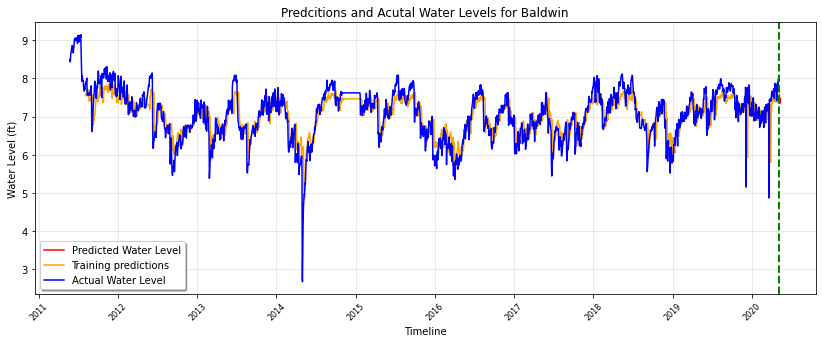

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2011-08-05'
START_DATE_FOR_PLOTTING2 ='2011-05-26'
test1_Bald30=plt.figure()
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Daily_WL'], color='r', label='Predicted Water Level')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Daily_WL'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING2:].index, dataset_train.loc[START_DATE_FOR_PLOTTING2:]['Daily_WL'], color='b', label='Actual Water Level')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Water Levels for Baldwin', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Water Level (ft)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
test1_Bald30.show()

In [ ]:
test1_Bald30.savefig('test_Bald30.png',bbox_inches='tight')

In [ ]:
PREDICTION_TRAIN

,Daily_WL
2011-07-31,7.584710
2011-08-01,7.622765
2011-08-02,7.645791
2011-08-03,7.575021
2011-08-04,7.566708
...,...
2020-04-30,7.554011
2020-05-01,7.374696
2020-05-02,7.344081
2020-05-03,7.394247


In [ ]:
PREDICTIONS_FUTURE

,Daily_WL
2020-05-05,7.473269
2020-05-06,7.572366
2020-05-07,7.554011
2020-05-08,7.374696
2020-05-09,7.344081
2020-05-10,7.394247
2020-05-11,7.469206


## **PART 4**: Error

In [ ]:
PREDICTIONS_FUTURE=PREDICTIONS_FUTURE.reset_index()
PREDICTIONS_FUTURE=PREDICTIONS_FUTURE.rename(columns={'index':'DATE'})
PREDICTIONS_FUTURE

PREDICTION_TRAIN=PREDICTION_TRAIN.reset_index()
PREDICTION_TRAIN=PREDICTION_TRAIN.rename(columns={'index':'DATE'})
PREDICTION_TRAIN

,DATE,Daily_WL
0,2011-07-31,7.584710
1,2011-08-01,7.622765
2,2011-08-02,7.645791
3,2011-08-03,7.575021
4,2011-08-04,7.566708
...,...,...
2984,2020-04-30,7.554011
2985,2020-05-01,7.374696
2986,2020-05-02,7.344081
2987,2020-05-03,7.394247


In [ ]:
PREDICTIONS_FUTURE.to_csv('FUTURE_Baldwin.csv')

In [ ]:
PREDICTIONS_FUTURE

,DATE,Daily_WL
0,2020-05-05,7.473269
1,2020-05-06,7.572366
2,2020-05-07,7.554011
3,2020-05-08,7.374696
4,2020-05-09,7.344081
5,2020-05-10,7.394247
6,2020-05-11,7.469206


In [ ]:
PREDICTION_TRAIN['DATE']= pd.to_datetime(PREDICTION_TRAIN['DATE'])
PREDICTIONS_FUTURE['DATE']=pd.to_datetime(PREDICTIONS_FUTURE['DATE'])
#Baldwin['Daily_WL']=Baldwin[['Daily_WL']].apply(stats.zscore)
bw = Baldwin[['DATE', 'Daily_WL', 'PRCP']].copy()
bw['DATE']= pd.to_datetime(bw['DATE'])
error=pd.merge(bw,PREDICTION_TRAIN, on='DATE')
error=error.rename(columns={'Daily_WL_x':'Actual', 'Daily_WL_y':'Prediction'})
error=error.drop(columns=['PRCP'])
error['ERROR']=abs(error['Actual']-error['Prediction'])
error

,DATE,Actual,Prediction,ERROR
0,2011-07-31,7.725833,7.584710,0.141124
1,2011-08-01,7.727500,7.622765,0.104735
2,2011-08-02,7.716667,7.645791,0.070876
3,2011-08-03,7.715833,7.575021,0.140812
4,2011-08-04,7.845000,7.566708,0.278292
...,...,...,...,...
2984,2020-04-30,7.732500,7.554011,0.178489
2985,2020-05-01,7.901667,7.374696,0.526971
2986,2020-05-02,7.977500,7.344081,0.633419
2987,2020-05-03,8.007500,7.394247,0.613253


0.00011599858601840651
3.3137819925944005


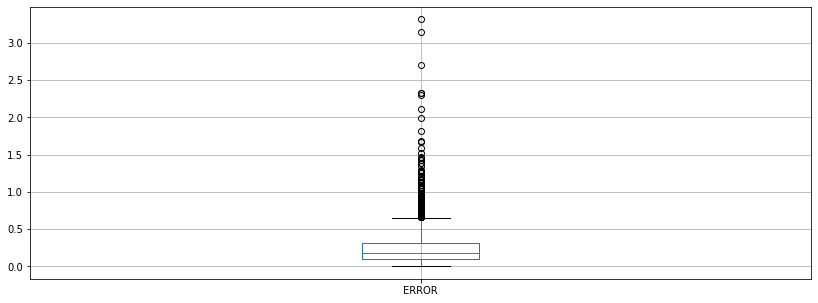

In [ ]:
print(error['ERROR'].min())
print(error['ERROR'].max())
error.boxplot(column=['ERROR'], return_type='axes')

In [ ]:
error.describe()

,Actual,Prediction,ERROR
count,2989.000000,2989.000000,2989.000000
mean,7.036001,7.036954,0.245185
std,0.618299,0.439721,0.247370
min,2.670833,4.840408,0.000116
25%,6.647500,6.732107,0.093432
50%,7.110833,7.122278,0.182733
75%,7.524167,7.410874,0.319013
max,8.310000,7.860366,3.313782


slope b1 is 0.5941969344957125
intercept b0 is 2.8561870198848114


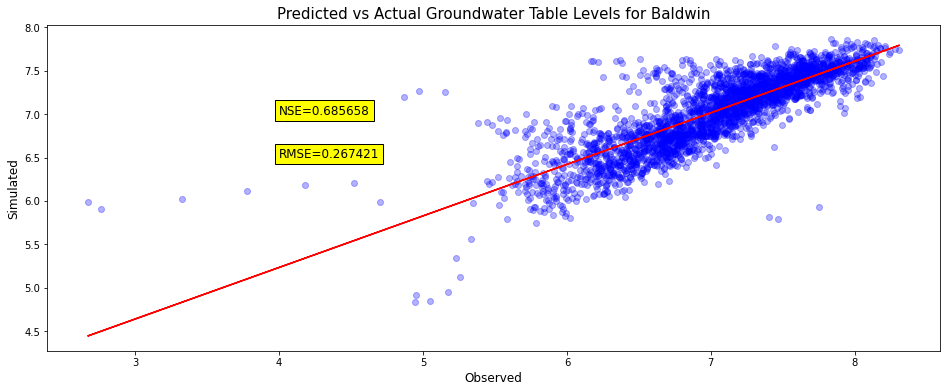

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

graph2_Bald=plt.figure(figsize=(16, 6))

x=np.array(error['Actual'])
y=np.array(error['Prediction'])

n = np.size(x)
  
x_mean = np.mean(x)
y_mean = np.mean(y)
x_mean,y_mean
  
Sxy = np.sum(x*y)- n*x_mean*y_mean
Sxx = np.sum(x*x)-n*x_mean*x_mean
  
b1 = Sxy/Sxx
b0 = y_mean-b1*x_mean
print('slope b1 is', b1)
print('intercept b0 is', b0)
  
#plt.scatter(x,y)
#plt.xlabel('Independent variable X')
#plt.ylabel('Dependent variable y')

y_pred = b1 * x + b0
  
plt.scatter(x, y, color = 'blue', alpha=0.3)
plt.plot(x, y_pred, color = 'red')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Simulated',  fontsize=12)
plt.text(4,7.0,'NSE=0.685658',bbox={"fc":"yellow"}, fontsize=12)
plt.text(4,6.5,'RMSE=0.267421',bbox={"fc":"yellow"}, fontsize=12)

plt.title("Predicted vs Actual Groundwater Table Levels for Baldwin", fontsize=15)
graph2_Bald.savefig('graph2_Bald.png',dpi=600,bbox_inches='tight')

In [ ]:
#Calculate NSE https://agrimetsoft.com/calculators/Nash%20Sutcliffe%20model%20Efficiency%20coefficient
a1=np.array(error['Actual']) 
a2=np.array(error['Prediction']) 
denominator = np.sum((a1 - np.mean(a1)) ** 2)
numerator = np.sum((a2 - a1) ** 2)
nse_val = 1 - numerator / denominator
print(nse_val)

In [ ]:
x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)


# printing values
print('Slope:',regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('MSE:',mse)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

In [ ]:
look_back = 500
std_part = 0.91  # use values from 0 to 1 if you have an idea what part of STD should be used.

look_back = 500
std_part = 2.0  # use values from 0 to 1 if you have an idea what part of STD should be used.
test_Bald30=plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
act_lb = error['Actual']
pred_lb = error['Prediction']
err_std = error['ERROR'].std(axis=0)
err_mean = error['ERROR'].mean(axis=0)
pred_upper = pred_lb + err_mean + err_std * std_part
pred_lower = pred_lb + err_mean - err_std * std_part
err_x = np.linspace(0, len(act_lb)-1, len(act_lb))
plt.plot(error['Actual'], label='Actual Water Level ')
plt.plot(error['Prediction'], label='Predicted Water Level')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
plt.legend()
plt.grid()
plt.title('Confidence Interval for Baldwin', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Water Level', family='Arial', fontsize=10)


test_Bald30.show()

In [ ]:
test_Bald30.savefig('CI_Bald30.png', bbox_inches='tight')

In [ ]:
x_values = Baldwin['Daily_WL']
y_values = Baldwin['PRCP']

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

In [ ]:
df = Baldwin[Baldwin['PRCP']!= 0]
df

In [ ]:
df.dtypes


In [ ]:
x_values = df['Daily_WL']
y_values = df['PRCP']

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)